<a href="https://colab.research.google.com/github/The20thDuck/Neuro-140-Project/blob/main/main_experiments/CIFAR_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as t
import torchvision
from tqdm import tqdm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Colormap
!pip install wandb -qqq
import wandb

In [ ]:
# train_data = torchvision.datasets.FashionMNIST("data", train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]), download=True)
# train_loader = t.utils.data.DataLoader(train_data, batch_size = 128, shuffle=True, num_workers=2)
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
getloader = lambda x: t.utils.data.DataLoader(x, batch_size = batch_size, shuffle=True, num_workers=2)
train_loader = getloader(train_data)
test_loader = getloader(test_data)

Files already downloaded and verified
Files already downloaded and verified


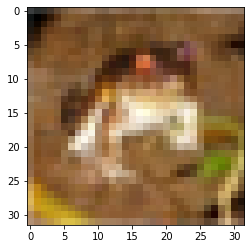

In [ ]:
plt.imshow(transforms.ToPILImage()(transforms.Normalize((-1, -1, -1), (2, 2, 2))(train_data[0][0].squeeze())))

In [ ]:
!pip install einops
!pip install pytorch-ignite pytorch-fid -q


In [ ]:
import einops
ngc = 64
latent_size = 100
num_classes = 10
emb_size = 128
in_channels = 3
wand_b = True
img_size = 32

class Generator(t.nn.Module):
  def __init__(self, 
               latent_size=latent_size, 
               emb_size = emb_size, 
               nhead=8,
               L1 = 4,
               L2 = 4,
               L3 = 2,
               img_size = img_size,
               in_channels=in_channels):
    super().__init__()
    self.emb_size = emb_size
    self.img_size = img_size
    # self.latent_size = latent_size
    self.linear1 = t.nn.Linear(latent_size, emb_size*(img_size//4)**2)
    self.pos_emb1 = t.nn.Parameter(t.randn(1, (img_size//4)**2, emb_size))
    self.block1 = t.nn.Sequential(
        *[t.nn.TransformerEncoderLayer(
        emb_size,
        nhead=nhead, 
        dim_feedforward=emb_size*4, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L1)]
    )
    self.pixel1 = t.nn.PixelShuffle(2)
    self.block2 = t.nn.Sequential(
        *[t.nn.TransformerEncoderLayer(
        emb_size//4,
        nhead=nhead, 
        dim_feedforward=emb_size, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L2)]
    )
    self.pixel2 = t.nn.PixelShuffle(2)
    self.block3 = t.nn.Sequential(
        *[t.nn.TransformerEncoderLayer(
        emb_size//16,
        nhead=nhead, 
        dim_feedforward=emb_size, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L3)]
    )
    self.project = t.nn.Linear(emb_size//16, in_channels)
    self.tanh = t.nn.Tanh()

  def forward(self, z):
    b = z.shape[0]
    emb = self.linear1(z).view((b, (self.img_size//4)**2, self.emb_size))
    emb = self.block1(emb + self.pos_emb1)
    emb_to_pixel = "b (h w) c -> b c h w"
    pixel_to_emb = "b c h w -> b (h w) c"

    pixels = einops.rearrange(emb, emb_to_pixel, h = self.img_size//4)
    pixels = self.pixel1(pixels)
    emb = einops.rearrange(pixels, pixel_to_emb, h = self.img_size//2)
    emb = self.block2(emb)
    pixels = einops.rearrange(emb, emb_to_pixel, h = self.img_size//2)
    pixels = self.pixel2(pixels)
    emb = einops.rearrange(pixels, pixel_to_emb, h = self.img_size)
    emb = self.block3(emb)
    emb = self.project(emb)
    pixels = einops.rearrange(emb, emb_to_pixel, h = self.img_size)
    return self.tanh(pixels)

class Generator_Conv(t.nn.Module):
  def __init__(self, latent_size=latent_size, num_classes = num_classes,  in_channels = in_channels):
    super().__init__()
    self.layers = t.nn.Sequential(
        t.nn.ConvTranspose2d(latent_size, ngc*4, 4, 1, 0),
        t.nn.BatchNorm2d(ngc*4),
        t.nn.ReLU(),
        t.nn.ConvTranspose2d(ngc*4, ngc*2, 4, 2, 1),
        t.nn.BatchNorm2d(ngc*2),
        t.nn.ReLU(),
        t.nn.ConvTranspose2d(ngc*2, ngc*1, 4, 2, 1),
        t.nn.BatchNorm2d(ngc),
        t.nn.ReLU(),
        t.nn.ConvTranspose2d(ngc*1, in_channels, 4, 2, 1),
        t.nn.Tanh()
    )
  def forward(self, z):
    return self.layers(z.unsqueeze(-1).unsqueeze(-1))

class PatchEmbedding(t.nn.Module):
  def __init__(self, in_channels, patch_size, emb_size, img_size, cls = True):
    super().__init__()
    self.cls = cls
    self.n = (img_size//patch_size)**2
    self.emb_size = emb_size
    if cls:
      self.cls_token = t.nn.Parameter(t.randn(1, 1, emb_size)) # b, n, emb_size. Add to the list of module params
      self.position_embeddings = t.nn.Parameter(t.randn(1, self.n + 1, emb_size)) # +1 for cls
    else:
      self.position_embeddings = t.nn.Parameter(t.randn(1, self.n, emb_size))

    self.projection = t.nn.Conv2d(in_channels, emb_size, patch_size, patch_size, 0)

  def forward(self, inputs):
    token_embeddings = einops.rearrange(self.projection(inputs), 'b c h w -> b (h w) c')
    b = inputs.shape[0]
    if self.cls:
      cls_embeddings = self.cls_token.repeat((b, 1, 1))
      # print(cls_embeddings.shape, token_embeddings.shape, self.position_embeddings.shape)
      return t.cat((cls_embeddings, token_embeddings), dim = 1) + self.position_embeddings
    else:
      return token_embeddings + self.position_embeddings

class ClassificationHead(t.nn.Module):
  def __init__(self, num_classes, emb_size):
    super().__init__()
    self.ln = t.nn.LayerNorm((emb_size,), eps = 1e-12)
    self.layer = t.nn.Linear(emb_size, num_classes)

  def forward(self, x):
    return self.layer(self.ln(x)[:,0,:])


class Discriminator(t.nn.Module):
  def __init__(self, in_channels: int = in_channels, patch_size: int = 2, emb_size: int = emb_size, nhead=8, img_size=img_size, num_classes=1, L1 = 3, L2 = 3, from_hugging = False):
    super().__init__()
    self.img_size = img_size
    self.patch_emb1 = PatchEmbedding(in_channels, patch_size, emb_size, img_size, cls=False)
    self.patch_emb2 = PatchEmbedding(in_channels, patch_size*2, emb_size, img_size, cls=False)
    self.cls_token = t.nn.Parameter(t.randn(1, 1, emb_size*2))
    # self.from_hugging = from_hugging
    # if from_hugging:
    #   config = ViTConfig(hidden_size=emb_size, num_hidden_layers = L, num_attention_heads = nhead, intermediate_size=emb_size*4, patch_size=patch_size, image_size=imgsize, encoder_stride=patch_size)
    #   self.encoder = ViTForImageClassification(config).vit.encoder
    # else:
    self.block1 = t.nn.Sequential(*[
      t.nn.TransformerEncoderLayer(
        emb_size,
        nhead=nhead, 
        dim_feedforward=emb_size*4, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L1)])
    self.avgpool = t.nn.AvgPool2d(2)
    self.block2 = t.nn.Sequential(*[
      t.nn.TransformerEncoderLayer(
        emb_size*2,
        nhead=nhead, 
        dim_feedforward=emb_size*4, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L2)])
    self.classifier = ClassificationHead(num_classes, emb_size=emb_size*2)

  def forward(self, x):
    emb1 = self.patch_emb1(x)
    stage1 = self.block1(emb1)
    emb_to_pixel = "b (h w) c -> b c h w"
    pixel_to_emb = "b c h w -> b (h w) c"
    stage1 = einops.rearrange(stage1, emb_to_pixel, h = self.img_size//2)
    stage1 = self.avgpool(stage1)
    stage1 = einops.rearrange(stage1, pixel_to_emb, h = self.img_size//4)
    emb2 = self.patch_emb2(x)
    emb2 = t.cat((emb2, stage1), dim = -1)
    b = x.shape[0]
    cls_embeddings = self.cls_token.repeat((b, 1, 1))
    emb2 = t.cat((cls_embeddings, emb2), dim = 1)
    emb2 = self.block2(emb2)
    return t.sigmoid(self.classifier(emb2)).flatten()
    

class Discriminator_Conv(t.nn.Module):
  def __init__(self, num_classes=num_classes, in_channels = in_channels):
    super().__init__()
    self.layers = t.nn.Sequential(
        t.nn.Conv2d(in_channels, ngc, 4, 2, 1),
        t.nn.BatchNorm2d(ngc*1),
        t.nn.LeakyReLU(0.2),
        t.nn.Conv2d(ngc*1, ngc*2, 4, 2, 1),
        t.nn.BatchNorm2d(ngc*2),
        t.nn.LeakyReLU(0.2),
        t.nn.Conv2d(ngc*2, ngc*4, 4, 2, 1),
        t.nn.BatchNorm2d(ngc*4),
        t.nn.LeakyReLU(0.2),
        t.nn.Conv2d(ngc*4, 1, 4, 1, 0),
        t.nn.Sigmoid()
    )
  def forward(self, x):
    return self.layers(x).flatten()


In [ ]:
wandb.login()

True

In [ ]:


# arch = "Transformer"

# if wand_b:
#   wandb.init(
#       # Set the project where this run will be logged
#       project="Neuro-140", 
#       # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
#       name=f"transformer_gen_{run}", 
#       # Track hyperparameters and run metadata
#       config={
#       "learning_rate": lr,
#       "emb_size": emb_size,
#       "architecture": arch
#       })

In [ ]:
from pytorch_fid.inception import InceptionV3

device = "cuda"
dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)

class WrapperInceptionV3(t.nn.Module):
    
    def __init__(self, fid_incv3):
        super().__init__()
        self.fid_incv3 = fid_incv3
    
    @t.no_grad()
    def forward(self, x):
        y = self.fid_incv3(x)
        y = y[0]
        y = y[:, :, 0, 0]
        return y

wrapper_model = WrapperInceptionV3(model)
wrapper_model.eval();

In [ ]:
from ignite.metrics import FID
from ignite.engine import Engine
import ignite.distributed as idist
def process_function(engine, batch):
  return batch

from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
engine = Engine(process_function)
metric = FID(num_features=dims, feature_extractor=wrapper_model, device=idist.device())
metric.attach(engine, "fid")

In [ ]:
def calc_fid(metric, gen, latent_size):
  metric.reset()
  gen.eval()
  with t.no_grad():
    for i, (x, y) in enumerate(tqdm(train_loader)):
      b = x.shape[0]
      z = t.randn(b, latent_size).cuda()
      gz = gen(z)
      if in_channels == 1:
        gz = t.tile(gz, (1, 3, 1, 1))
        x = t.tile(x, (1, 3, 1, 1))
      gz_resize = preprocess(gz)
      x_resize = preprocess(x)
      metric.update([x_resize, gz_resize])
      if i == 100:
        break
  gen.train()
  return (metric.compute())

In [ ]:
# wandb.finish()

In [ ]:
# Initialize Sweep 
sweep_config = {
  "method": "grid",
  "parameters": {
      "lr": {
          "values": [1e-4, 3e-5, 1e-5]
      },
      "gen_emb_size": {
          "value": 256
      },
      "disc_emb_size": {
          "value": 128
      },
      "latent_size": {
          "value": 100
      },
      "gen": {
          "values": ["transformer", "conv"]
      },
      "disc": {
          "value": "transformer"
      },
      "epochs": {
          "value": 50
      }
  }
}
# sweep_id = wandb.sweep(sweep_config, project="CIFAR-transformer")

In [ ]:
def train(config, wand_b = True):
    lr = config.lr
    beta1 = 0.5
    if config.gen == "conv":
      gen = Generator_Conv(latent_size=config.latent_size).cuda()
    else:
      gen = Generator(latent_size=config.latent_size, emb_size=config.gen_emb_size).cuda()
    if config.disc == "conv":
      disc = Discriminator_Conv().cuda()
    else:
      disc = Discriminator(emb_size=config.disc_emb_size).cuda()
    optim_g = t.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
    optim_d = t.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))
    criterion = t.nn.BCELoss()

    iter = 0
    epoch = 0
    fixed_z = t.randn(10, config.latent_size).cuda()

    # begin training
    num_epochs = config.epochs
    real_label = 1.
    fake_label = 0.


    d_losses = []
    g_losses = []
    dxs = []
    dgzs = []
    for e in range(num_epochs):
      epoch += 1
      for step, (x, _) in enumerate(tqdm(train_loader)):
        iter += 1
        # lab = t.nn.functional.one_hot(y.cuda(), num_classes = num_classes).float()
        # update G
        gen.zero_grad()
        disc.zero_grad()
        b = x.shape[0]
        with t.no_grad():
          z = t.randn(b, config.latent_size).cuda()
        gz = gen(z)
        dgz = disc(gz)
        
        g_loss = criterion(dgz, t.full((b,), real_label).cuda())
        g_losses.append(g_loss.item())
        g_loss.backward()
        optim_g.step()
        # update D
        disc.zero_grad()
        dx = disc(x.cuda())
        dgz = disc(gz.detach())
        dxs.append(dx.detach())
        dgzs.append(dgz.detach())

        d_loss = criterion(dgz, t.full((b,), fake_label).cuda()) + criterion(dx, t.full((b,), real_label).cuda())
        d_losses.append(d_loss.item())
        d_loss.backward()
        optim_d.step()

        if iter % 100 == 0:
          L_g = t.tensor(g_losses[-100:]).mean()
          L_d = t.tensor(d_losses[-100:]).mean()
          dx_mean = t.cat(dxs[-100:]).mean().item()
          dgz_mean = t.cat(dgzs[-100:]).mean().item()
          d_losses = []
          g_losses = []
          dxs = []
          dgzs = []
          if wand_b:
            wandb.log({"G-Loss": L_g, 
                      "D-Loss": L_d,
                      "dx": dx_mean,
                      "dgz": dgz_mean,
                      "iter": iter
                      })

      with t.no_grad():
        ims = gen(fixed_z).cpu()
        
      fid = calc_fid(metric, gen, latent_size = config.latent_size)
      print(f"FID: {fid}")
      if wand_b:
        norm_images = transforms.Normalize((-1, -1, -1), (2, 2, 2))(ims)
        log_dict = {f"FID": fid,
                  #  f"{arch}/G-Loss": t.tensor(g_losses).mean(), 
                  #  f"{arch}/D-Loss": t.tensor(d_losses).mean(),
                  # f"Images": [wandb.Image(im.numpy()*255) for im in ims],
                  "Images": [wandb.Image(transforms.ToPILImage()(im)) for im in norm_images],
                  "epoch": epoch
                  }
        if epoch == num_epochs:
          log_dict.update({
              "FID_Final": fid
          })
        wandb.log(log_dict)

def train_config(config = None):
  with wandb.init(config=config):
    config = wandb.config
    train(config)

    

In [ ]:
!nvidia-smi

Thu May  5 15:24:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    40W / 300W |   4893MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# class dotdict(dict):
#     """dot.notation access to dictionary attributes"""
#     __getattr__ = dict.get
#     __setattr__ = dict.__setitem__
#     __delattr__ = dict.__delitem__
# train(config = dotdict({"lr": 1e-4, "gen_emb_size": 256, "disc_emb_size": 128, "latent_size": 100, "gen": "transformer", "disc": "transformer", "epochs": 50}), wand_b = False)

In [ ]:
wandb.agent("v66yl21b", train_config, project="CIFAR-transformer")



wandb: Agent Starting Run: nrb23vgo with config:
wandb: 	disc: transformer
wandb: 	disc_emb_size: 192
wandb: 	epochs: 50
wandb: 	gen: conv
wandb: 	gen_emb_size: 256
wandb: 	latent_size: 100
wandb: 	lr: 1e-05
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


 26%|██▌       | 100/391 [00:42<02:05,  2.33it/s]


FID: 403.2853861436653


 26%|██▌       | 100/391 [00:43<02:06,  2.30it/s]


FID: 441.2788465229978


 26%|██▌       | 100/391 [00:43<02:05,  2.32it/s]


FID: 420.548186692905


 26%|██▌       | 100/391 [00:42<02:05,  2.33it/s]


FID: 431.74692929225716


 26%|██▌       | 100/391 [00:43<02:05,  2.33it/s]


FID: 420.1152291451159


 26%|██▌       | 100/391 [00:43<02:05,  2.32it/s]


FID: 349.0678537706375


 26%|██▌       | 100/391 [00:43<02:05,  2.32it/s]


FID: 361.4931913180464


 26%|██▌       | 100/391 [00:42<02:04,  2.33it/s]


FID: 321.8982645310373


 26%|██▌       | 100/391 [00:43<02:05,  2.32it/s]


FID: 285.7509777277711


 26%|██▌       | 100/391 [00:42<02:04,  2.33it/s]


FID: 261.3822115381628


 26%|██▌       | 100/391 [00:42<02:05,  2.33it/s]


FID: 246.58681945438332


 26%|██▌       | 100/391 [00:42<02:05,  2.33it/s]


FID: 245.5463076834334


 26%|██▌       | 100/391 [00:42<02:04,  2.33it/s]


FID: 244.9238335557945


 26%|██▌       | 100/391 [00:43<02:05,  2.32it/s]


FID: 256.8611031801115


 26%|██▌       | 100/391 [00:42<02:04,  2.33it/s]


FID: 280.97740670296173


 26%|██▌       | 100/391 [00:42<02:04,  2.33it/s]


FID: 244.4596366816936


 26%|██▌       | 100/391 [00:42<02:04,  2.33it/s]


FID: 233.25239685280462


 26%|██▌       | 100/391 [00:42<02:05,  2.33it/s]


FID: 236.82734743622322


 26%|██▌       | 100/391 [00:42<02:04,  2.34it/s]


FID: 206.4639617376729


 26%|██▌       | 100/391 [00:42<02:04,  2.34it/s]


FID: 200.44687435057307


 26%|██▌       | 100/391 [00:42<02:03,  2.35it/s]


FID: 199.20931837372467


 26%|██▌       | 100/391 [00:42<02:03,  2.35it/s]


FID: 195.00399850420126


 26%|██▌       | 100/391 [00:42<02:03,  2.35it/s]


FID: 187.20012956831548


 26%|██▌       | 100/391 [00:42<02:03,  2.35it/s]


FID: 192.0745829089151


 26%|██▌       | 100/391 [00:42<02:03,  2.35it/s]


FID: 187.1557129597988


  6%|▋         | 25/391 [00:10<02:33,  2.38it/s]